In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json 
import math 
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer   
import textwrap
import seaborn as sns

In [2]:
model_column = 'sentence-transformers/all-mpnet-base-v2'
model_name = "all-mpnet-base-v2"
outdated_models = ["jinaai/jina-embeddings-v3",
          "jinaai/jina-embeddings-v4",
           "Snowflake/snowflake-arctic-embed-l-v2.0", "BAAI/bge-m3", 
           'sentence-transformers/all-MiniLM-L6-v2', 
           'Qwen/Qwen3-Embedding-0.6B']

In [3]:
df = pd.read_parquet('data/speech_embeddings.parquet')

In [4]:
# delete all columns of outdated models
for outdated_model in outdated_models:
    if outdated_model in df.columns:
        del df[outdated_model]

In [5]:
df.head()

,Unnamed: 0,speaker,text,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,...,multispeaker,link,translatedText,translationSource,year,block,party,migration_prob,sentence-transformers/all-mpnet-base-v2,google/embeddinggemma-300m
492,492,Karen Melchior,"Mr President, thank you very much to the Commi...",2024-04-24,22. Advance passenger information: enhancing a...,8,bill_26075_ID bill_26076_ID bill_26075_ID bi...,6401.0,9,False,...,False,https://www.europarl.europa.eu/doceo/document/...,"Mr President, thank you very much to the Commi...",original_gm,2024,liberal,ELDR/ALDE/Renew,0.393282,"[0.009955298, 0.01231596, -0.031741396, 0.0164...","[-0.06368264, -0.01790871, 0.008169121, 0.0173..."
844,844,Tineke Strik,"Mr President, Commissioner. People who flee wa...",2024-04-23,17. EU-Egypt strategic and comprehensive partn...,9,,6403.0,9,False,...,False,https://www.europarl.europa.eu/doceo/document/...,"Mr President, Commissioner. People who flee wa...",original_gm,2024,green,Greens/EFA,0.423501,"[0.050362997, 0.031640317, 0.0033627285, 0.010...","[-0.06358229, 0.05332363, -0.006831329, 0.0041..."
1050,1050,Anabela Rodrigues,"Senhora Presidente, em 2024, o tráfico de sere...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,10,bill_241_ID bill_241_ID,6402.0,9,False,...,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, in 2024, human trafficking co...",machine_gm,2024,left,NGL/The Left,0.375925,"[-0.016886365, 0.02107416, 0.022850083, -0.003...","[-0.049918693, -0.001202861, -0.008896867, -0...."
1054,1054,Beata Kempa,Pani Przewodnicząca! Pani Komisarz! Potrzebuje...,2024-04-22,20. Amending Directive 2011/36/EU on preventin...,14,bill_241_ID bill_241_ID,6400.0,9,False,...,False,https://www.europarl.europa.eu/doceo/document/...,"Madam Commissioner! We need very specific, ver...",machine_gm,2024,(extreme)_right,ECR,0.256493,"[0.0069901105, -0.003832352, 0.014021035, 0.03...","[-0.035047594, 0.03835739, -0.051198084, 0.050..."
1056,1056,Dorien Rookmaker,"Voorzitter, dank u wel, meneer Engerer, want u...",2024-04-22,20. Amending Directive 2011/36/EU on preventin...,16,bill_241_ID bill_241_ID,6400.0,9,False,...,False,https://www.europarl.europa.eu/doceo/document/...,"Madam President, thank you, Mr Engerer, becaus...",machine_gm,2024,(extreme)_right,ECR,0.475315,"[0.05082612, -0.035786744, 0.014009577, 0.0413...","[-0.06766452, 0.015919995, -0.019874139, -0.01..."


In [95]:
test_sentence = "Many immigrants are terrorists"

In [96]:
model = SentenceTransformer(model_name)
test_embedding = model.encode_query(test_sentence)

In [97]:
df['similarity'] = df[model_column].apply(lambda x: cosine_similarity([test_embedding], [x])[0][0])

In [98]:
# top 5 most similar speeches
top5 = df.nlargest(5, 'similarity')
for _, row in top5.iterrows():
    print(f"{row['speaker']}  (sim={row['similarity']:.4f})")
    print(textwrap.fill(row['translatedText'], width=90))
    print()

Mike Hookem  (sim=0.5364)
Mr President, we have heard much in this Chamber about how the terror attacks have nothing
to do with the open-door policy EU leaders foisted upon Members, which saw migrants claim
refugee status they were not entitled to. Daesh boasted they would flood our continent
with jihad fighters, although Members here in the Chamber derided those of us who pointed
this out. We know that two of the murderers involved in the Paris killings came to the
continent via Greece, using false Syrian passports. What is this if it is not a direct
link between uncontrolled immigration and terrorism? I reject this idea put forward by
people like President Juncker that terrorism is a risk we must live with to uphold the
EU’s ideals of freedom of movement. The migrant crisis has put the well-being of migrants
ahead of the safety of its citizens by making us vulnerable to attack in our towns and
cities. Come the UK’s referendum, voters must look at the negligence of the EU when it
come

In [99]:
agg = (
    df
    .groupby(["block", "year"])
    .agg(
        mean_similarity=("similarity", "mean"),
        median_similarity=("similarity", "median"),
        n_speeches=("similarity", "size")
    )
    .reset_index()
)


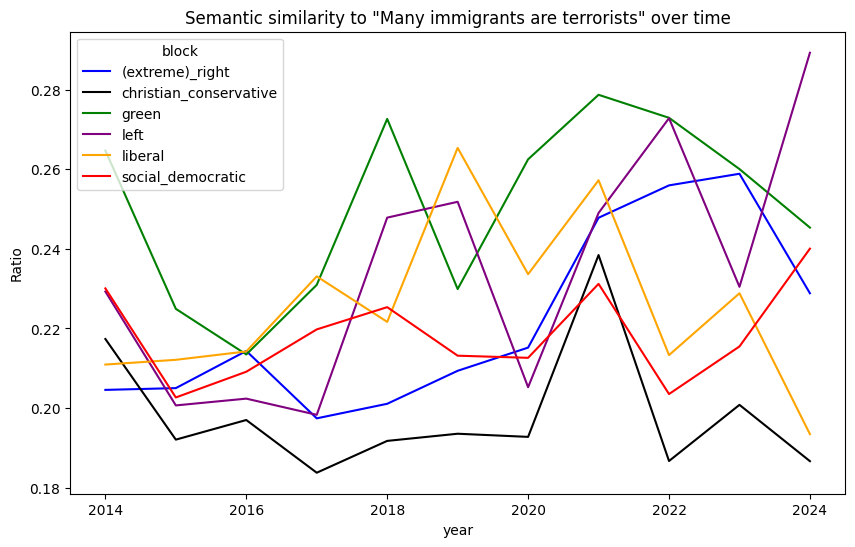

In [100]:
with open('plotting_parameters/color_maps/color_map_block.json') as f:
    color_map = json.load(f)
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=agg,
    x="year",
    y="mean_similarity",
    hue="block",
    palette=color_map
)
plt.ylabel("Ratio")
plt.title("Semantic similarity to" + f' "{test_sentence}" over time')
plt.show()


In [101]:
# number of speeches with similarity above threshold (normalized by total speeches per year)
threshold = 0.3
agg_threshold = (
    df
    .assign(above_threshold=lambda x: x['similarity'] > threshold)
    .groupby(["block", "year"])
    .agg(n_speeches_above_threshold=("above_threshold", "sum"))
    .reset_index()
)

# normalize by total speeches in each year
total_per_year = df.groupby("year").size().rename("n_speeches_year").reset_index()
agg_threshold = agg_threshold.merge(total_per_year, on="year")
agg_threshold["n_speeches_above_threshold"] = (
    agg_threshold["n_speeches_above_threshold"] / agg_threshold["n_speeches_year"]
)

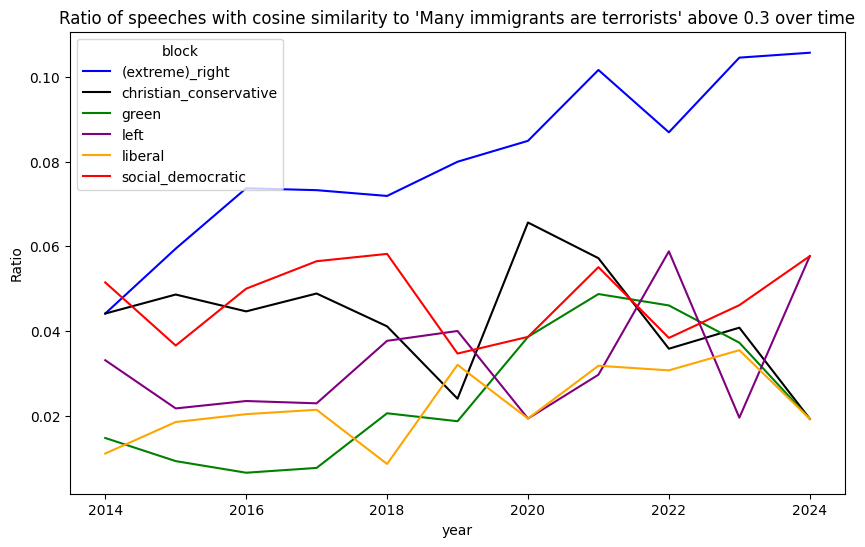

In [102]:
# plot number of speeches above threshold over time
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=agg_threshold,
    x="year",
    y="n_speeches_above_threshold",
    hue="block",
    palette=color_map
)
plt.ylabel("Ratio")
plt.title(f"Ratio of speeches with cosine similarity to '{test_sentence}' above {threshold} over time")
plt.show()

In [103]:
# number of speeches with similarity above certain percentile
percentile = 90
similarity_threshold = np.percentile(df['similarity'], percentile)
agg_percentile = (
    df
    .assign(above_percentile=lambda x: x['similarity'] > similarity_threshold)
    .groupby(["block", "year"])
    .agg(n_speeches_above_percentile=("above_percentile", "sum"))
    .reset_index()
)

# normalize by total speeches in each year
total_per_year = df.groupby("year").size().rename("n_speeches_year").reset_index()
agg_percentile = agg_percentile.merge(total_per_year, on="year")
agg_percentile["n_speeches_above_percentile"] = (
    agg_percentile["n_speeches_above_percentile"] / agg_percentile["n_speeches_year"]
)

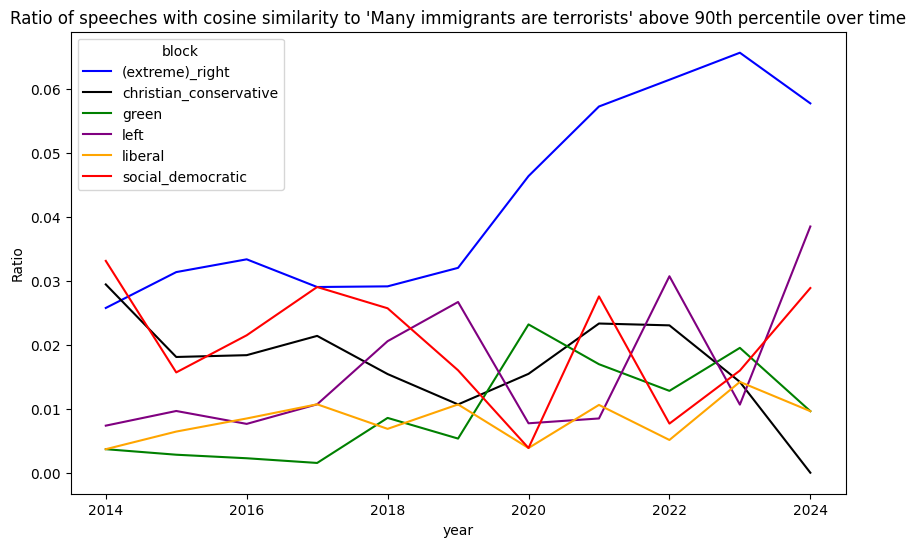

In [104]:
# plot number of speeches above percentile over time
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=agg_percentile,
    x="year",
    y="n_speeches_above_percentile",
    hue="block",
    palette=color_map
)
plt.ylabel("Ratio")
plt.title(f"Ratio of speeches with cosine similarity to '{test_sentence}' above {percentile}th percentile over time")
plt.show()